# LeNet

In [1]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import RandomCrop, RandomRotation

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_data(training=True):
    transform_ = transforms.Compose(
        [RandomRotation(45),
         RandomCrop(28),
         transforms.ToTensor()]
    )

    data = torchvision.datasets.MNIST(
        root='./data/',
        train=training,
        download=True,
        transform=transform_,
    )

    loader = torch.utils.data.DataLoader(
        data,
        batch_size=8,
        shuffle=True,
        num_workers=2,
    )

    return loader

In [3]:
def num_flat_features(self, x):
    """return the number of flat features from a pytorch variable"""
    return int(np.prod(x.size()[1:]))


In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional Layers
        # 1 image, 6 output channels, 5*5 convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 120)  # layer 1 activation
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        forward must be overwritten in torch model class
        """
        # Convolutional Layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # add pooling layer
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        x = x.view(-1, 256)  # flatten for fully connected layers

        # fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [5]:
net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [6]:
dataloader = load_data(training=True)

In [7]:
scores = []

running_loss = 0.0
correct = 0
total = 0
for i, (inputs, labels) in enumerate(dataloader, 0):

    # wrap features in Variable
    inputs, labels = Variable(inputs), Variable(labels)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()  # compute back propagation
    optimizer.step()  # update model parameters

    running_loss += loss.data[0]

    if i % 100 == 99:  # print every 2000 mini-batches
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        accuracy = 100.*correct/total
        
        scores.append((i+1, running_loss/100, accuracy)) 
        
        # print results
        if i % 500 == 499:
            print('Batch: %5d - Loss: %.4f' % (i+1, running_loss/100))
            print("Accuracy: {:.2f}%".format(accuracy))
            
        running_loss = 0.0    
        
print('Finished Training')

Batch:   500 - Loss: 0.5910
Accuracy: 75.00%
Batch:  1000 - Loss: 0.3588
Accuracy: 76.25%
Batch:  1500 - Loss: 0.3016
Accuracy: 80.00%
Batch:  2000 - Loss: 0.2220
Accuracy: 83.75%
Batch:  2500 - Loss: 0.2121
Accuracy: 86.50%
Batch:  3000 - Loss: 0.1969
Accuracy: 87.92%
Batch:  3500 - Loss: 0.1586
Accuracy: 88.57%
Batch:  4000 - Loss: 0.2141
Accuracy: 89.69%
Batch:  4500 - Loss: 0.1453
Accuracy: 90.56%
Batch:  5000 - Loss: 0.1633
Accuracy: 91.00%
Batch:  5500 - Loss: 0.1534
Accuracy: 91.82%
Batch:  6000 - Loss: 0.1847
Accuracy: 91.67%
Batch:  6500 - Loss: 0.1293
Accuracy: 91.35%
Batch:  7000 - Loss: 0.1114
Accuracy: 91.25%
Batch:  7500 - Loss: 0.1033
Accuracy: 91.67%
Finished Training


In [8]:
iterations = [i[0] for i in scores]
loss_scores = [i[1] for i in scores]
acc_scores = [i[2] for i in scores]

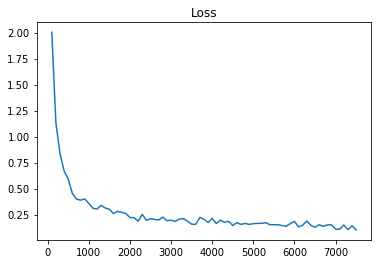

In [9]:
plt.plot(iterations, loss_scores);
plt.title('Loss')
plt.show()

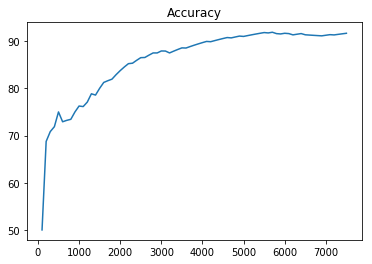

In [10]:
plt.plot(iterations, acc_scores);
plt.title('Accuracy')
plt.show()